# Introduction
Jack Wilson
10/26/2025

This notebook outlines the cleaning and merging of raw data into intermediate and final dataframes

# Import Modules

In [1]:
import pandas as pd
import numpy as np

import os, sys, re

from datetime import timedelta

from matplotlib import pyplot as plt

In [2]:
# Connects notebook to 'src' Package
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), '..'))
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

from src.data_functions import load_id_map, save_id_map, constructor_mapping

# DataFrame Display Options

In [6]:
pd.set_option('display.max_columns', None)
pd.set_option("display.max_colwidth", None)
pd.set_option('display.max_rows', None)

# Prep for Merge

## ID Map

### Load

In [102]:
id_map = load_id_map('../data/raw/circuit_id_map.pkl')

### Fix Circuit ID Map
Austria & Styria (2020, 2021) are the same race

Great Britain & 70th Anniversary (2020) are the same race

In [103]:
# Ensure Austria and Styria have the same circuit ID
if 'Styria' in id_map and 'Austria' in id_map:
    id_map_styria = id_map['Styria']
    id_map['Styria'] = id_map['Austria']

# Ensure Great Britain and 70th Anniversary have the same circuit ID
if '70th Anniversary' in id_map and 'Great Britain' in id_map:
    id_map_anniversary = id_map['70th Anniversary']
    id_map['70th Anniversary'] = id_map['Great Britain']

print(f"Styria: {id_map_styria} -> {id_map.get('Styria')}")
print(f"Austria: {id_map.get('Austria')}")
print(f"70th Anniversary: {id_map_anniversary} -> {id_map.get('70th Anniversary')}")
print(f"Great Britain: {id_map.get('Great Britain')}")

Styria: 9 -> 9
Austria: 9
70th Anniversary: 10 -> 10
Great Britain: 10


### Save

In [104]:
save_id_map('../data/raw/circuit_id_map.pkl', id_map)

## Race Results 2001-2017

### Load

In [76]:
races_2001 = pd.read_csv('../data/raw/race_results_raw_2001-2017.csv')

### Convert Date

In [77]:
# Process date column
for i, date in enumerate(races_2001['date']):
    if '-' in date:
        races_2001.at[i, 'date'] = date.split('-')[1].strip()

# Convert to datetime
races_2001['date'] = pd.to_datetime(races_2001['date'], format='mixed')
races_2001.head(10)

,date,driver_id,position,driver_name,points
0,2001-03-04,1,1,Michael Schumacher,10.0
1,2001-03-04,2,2,David Coulthard,6.0
2,2001-03-04,3,3,Rubens Barrichello,4.0
3,2001-03-04,4,4,Nick Heidfeld,3.0
4,2001-03-04,5,5,Heinz-Harald Frentzen,2.0
5,2001-03-04,6,6,Kimi Räikkönen,1.0
6,2001-03-04,7,7,Olivier Panis,0.0
7,2001-03-04,8,8,Luciano Burti,0.0
8,2001-03-04,9,9,Jean Alesi,0.0
9,2001-03-04,10,10,Jos Verstappen,0.0


### Create Year and Round Columns
These columns will help after the merge with 2018+ data. Gives same features across both datasets to make sorting easier

In [78]:
# Create year column
races_2001['year'] = races_2001['date'].dt.year

# Create round column
races_2001 = races_2001.sort_values(['year', 'date'])
races_2001['round'] = races_2001.groupby('year')['date'].transform(lambda x: x.rank(method='dense').astype(int))

races_2001.head(25)

,date,driver_id,position,driver_name,points,year,round
0,2001-03-04,1,1,Michael Schumacher,10.0,2001,1
1,2001-03-04,2,2,David Coulthard,6.0,2001,1
2,2001-03-04,3,3,Rubens Barrichello,4.0,2001,1
3,2001-03-04,4,4,Nick Heidfeld,3.0,2001,1
4,2001-03-04,5,5,Heinz-Harald Frentzen,2.0,2001,1
5,2001-03-04,6,6,Kimi Räikkönen,1.0,2001,1
6,2001-03-04,7,7,Olivier Panis,0.0,2001,1
7,2001-03-04,8,8,Luciano Burti,0.0,2001,1
8,2001-03-04,9,9,Jean Alesi,0.0,2001,1
9,2001-03-04,10,10,Jos Verstappen,0.0,2001,1


### Convert Position to Numeric

In [79]:
# Converts position to numeric, or changes classification to numeric
def convert_position(row, prev_position=None):
    try:
        return int(row['position'])
    except (ValueError, TypeError):
        if prev_position is not None:
            return prev_position + 1
        else:
            return 1

# Apply conversion
prev_pos = None
converted_positions = []
for idx, row in races_2001.iterrows():
    current_pos = convert_position(row, prev_pos)
    converted_positions.append(current_pos)
    prev_pos = current_pos

races_2001['position'] = converted_positions
races_2001['position'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24], dtype=int64)

### Save

In [80]:
races_2001.to_csv('../data/clean/race_results_clean_2001-2017.csv', encoding='utf-8', index=False)

## Race Results 2018+

### Load

In [105]:
races_2018 = pd.read_csv('../data/raw/race_results_raw_2018+.csv')

### Fix circuit_id in Results

In [106]:
# Change circuit_id from 23 to 10 and from 22 to 9 
rows_replaced = (races_2018['circuit_id'] == 23).sum() + (races_2018['circuit_id'] == 22).sum()
races_2018['circuit_id'] = races_2018['circuit_id'].replace({23: 10, 22: 9})

print(f"Rows replaced: {rows_replaced}")

Rows replaced: 60


### Separate Position Status

In [107]:
races_2018['end_position'].unique()

array(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', 'NC', '16', '17', '18', '19', '20', 'DQ'],
      dtype=object)

In [108]:
# Initialize new columns
end_positions = []
statuses = []
current_position = 1
current_race = None

# Group by each race
for idx, row in races_2018.iterrows():
    # Check if its a new race
    if current_race != row['race_url']:
        current_race = row['race_url']
        current_position = 1

    pos = row['end_position']

    try:
        # Try converting to int to validate position
        numeric_pos = int(pos)
        end_positions.append(numeric_pos)
        statuses.append('CLAS')
        current_position = numeric_pos + 1
    except ValueError:
        # Not a number so need to assign position and keep status
        if pos in ['NC', 'DQ']:
            end_positions.append(current_position)
            statuses.append(pos)
            current_position += 1
        else:
            end_positions.append(current_position)
            statuses.append('DNF')
            current_position += 1

# Assign back to dataframe
races_2018['end_position'] = end_positions
races_2018['position_status'] = statuses

print(f"End positions:\n{races_2018['end_position'].unique()}")
print(f"Position statuses:\n{races_2018['position_status'].unique()}")

End positions:
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
Position statuses:
['CLAS' 'NC' 'DQ']


### Impute NA Lap Counts

In [109]:
races_2018.isna().sum()

race_id            0
driver_id          0
circuit_id         0
team_id            0
year               0
race_url           0
circuit_name       0
driver_name        0
team_name          0
end_position       0
points             0
laps_completed     5
position_status    0
dtype: int64

In [110]:
# Impute 0 for laps_completed if null
races_2018['laps_completed'] = races_2018['laps_completed'].fillna(0)
races_2018['laps_completed'].isna().sum()

0

### Map Team Name

In [111]:
print(f"Unique team names before mapping:\n{races_2018['team_name'].unique()}")

# Map team names to constructor common names using existing constructor_mapping
races_2018['team_name'] = races_2018['team_name'].map(constructor_mapping['team_id']).fillna(races_2018['team_name'])

print(f"Unique team names after mapping:\n{races_2018['team_name'].unique()}")

Unique team names before mapping:
['Ferrari' 'Mercedes' 'Red Bull Racing TAG Heuer' 'McLaren Renault'
 'Renault' 'Force India Mercedes' 'Sauber Ferrari' 'Williams Mercedes'
 'Scuderia Toro Rosso Honda' 'Haas Ferrari' 'Red Bull Racing Honda'
 'Alfa Romeo Racing Ferrari' 'Racing Point BWT Mercedes'
 'AlphaTauri Honda' 'McLaren Mercedes' 'Aston Martin Mercedes'
 'Alpine Renault' 'Alfa Romeo Ferrari' 'AlphaTauri RBPT'
 'Aston Martin Aramco Mercedes' 'Red Bull Racing RBPT'
 'Red Bull Racing Honda RBPT' 'AlphaTauri Honda RBPT'
 'Kick Sauber Ferrari' 'RB Honda RBPT' 'McLaren' 'Red Bull Racing'
 'Williams' 'Aston Martin' 'Kick Sauber' 'Alpine' 'Racing Bulls'
 'Haas F1 Team']
Unique team names after mapping:
['Ferrari' 'Mercedes' 'Red Bull' 'McLaren' 'Renault' 'Force India'
 'Sauber' 'Williams' 'Toro Rosso' 'Haas' 'Alfa Romeo' 'Racing Point'
 'AlphaTauri' 'Aston Martin' 'Alpine' 'Racing Bulls' 'Kick Sauber']


In [112]:
races_2018.head()

,race_id,driver_id,circuit_id,team_id,year,race_url,circuit_name,driver_name,team_name,end_position,points,laps_completed,position_status
0,1,60,1,1,2018,https://www.formula1.com/en/results/2018/races/979/australia/race-result,Australia,Sebastian Vettel,Ferrari,1,25.0,58.0,CLAS
1,1,57,1,2,2018,https://www.formula1.com/en/results/2018/races/979/australia/race-result,Australia,Lewis Hamilton,Mercedes,2,18.0,58.0,CLAS
2,1,6,1,1,2018,https://www.formula1.com/en/results/2018/races/979/australia/race-result,Australia,Kimi Räikkönen,Ferrari,3,15.0,58.0,CLAS
3,1,79,1,3,2018,https://www.formula1.com/en/results/2018/races/979/australia/race-result,Australia,Daniel Ricciardo,Red Bull,4,12.0,58.0,CLAS
4,1,12,1,4,2018,https://www.formula1.com/en/results/2018/races/979/australia/race-result,Australia,Fernando Alonso,McLaren,5,10.0,58.0,CLAS


### Save

In [113]:
races_2018.to_csv('../data/clean/race_results_clean_2018+.csv', encoding='utf-8', index=False)

## Practice Results

### Load

In [197]:
practices = pd.read_csv('../data/raw/pratice_results_raw.csv')

In [198]:
practices.head()

,race_id,driver_id,team_id,session_type,lap_time,lap_count,position
0,1,57,2,practice1,1:24.026,27,1
1,1,83,2,practice1,+0.551s,29,2
2,1,94,3,practice1,+0.745s,26,3
3,1,6,1,practice1,+0.849s,23,4
4,1,60,1,practice1,+0.969s,22,5


### Merge Emilia-Romagna 2020
This race didnt get scraped correctly because its URL has practice0 instead of 1, 2, or 3, so it is scraped and merged manually

In [199]:
ER2020 = pd.read_csv('../data/raw/pratice_results_ER2020_raw.csv')
practices = pd.concat([practices, ER2020], ignore_index=True)
practices.head()

,race_id,driver_id,team_id,session_type,lap_time,lap_count,position
0,1,57,2,practice1,1:24.026,27,1
1,1,83,2,practice1,+0.551s,29,2
2,1,94,3,practice1,+0.745s,26,3
3,1,6,1,practice1,+0.849s,23,4
4,1,60,1,practice1,+0.969s,22,5


### Add Recorded Lap Column

In [200]:
practices['recorded_lap_time'] = practices['lap_time'].notna()
practices.head()

,race_id,driver_id,team_id,session_type,lap_time,lap_count,position,recorded_lap_time
0,1,57,2,practice1,1:24.026,27,1,True
1,1,83,2,practice1,+0.551s,29,2,True
2,1,94,3,practice1,+0.745s,26,3,True
3,1,6,1,practice1,+0.849s,23,4,True
4,1,60,1,practice1,+0.969s,22,5,True


### Convert Lap Times

In [201]:
# Initialize variables to track base time for each race_id and session_type
current_race_id = None
current_session_type = None
base_time = None

for idx, row in practices.iterrows():
    lap_time = row['lap_time']
    
    # Check if starting a new race_id and session_type group
    if current_race_id != row['race_id'] or current_session_type != row['session_type']:
        current_race_id = row['race_id']
        current_session_type = row['session_type']
        base_time = None
    
    try:
        if pd.notna(lap_time):
            # Check if this is a base time
            if not lap_time.startswith('+'):
                if ':' in lap_time:
                    # Time in "min:sec.millisec" format
                    time_parts = re.split(r"[:.]", lap_time)
                    minutes = int(time_parts[0])
                    seconds = int(time_parts[1])
                    milliseconds = int(time_parts[2])
                else:
                    # Time in "sec.millisec" format
                    time_parts = lap_time.split('.')
                    minutes = 0
                    seconds = int(time_parts[0])
                    milliseconds = int(time_parts[1])
                
                # Convert to timedelta and store as base time
                base_time = timedelta(minutes=minutes, seconds=seconds, milliseconds=milliseconds)
                practices.at[idx, 'lap_time_clean'] = base_time
            else:
                if base_time is not None:
                    # Get rid of the + and s
                    time_clean = lap_time.strip('+s')
                    
                    # Parse the gap time
                    if ':' in time_clean:
                        # Gap time in "min:sec.millisec" format
                        time_parts = re.split(r"[:.]", time_clean)
                        gap_minutes = int(time_parts[0])
                        gap_seconds = int(time_parts[1])
                        gap_milliseconds = int(time_parts[2])
                    else:
                        # Gap time in "sec.millisec" format
                        time_parts = time_clean.split('.')
                        gap_minutes = 0
                        gap_seconds = int(time_parts[0])
                        gap_milliseconds = int(time_parts[1])
                    
                    # Convert gap to timedelta and add to base time
                    gap = timedelta(minutes=gap_minutes, seconds=gap_seconds, milliseconds=gap_milliseconds)
                    new_time = base_time + gap
                    practices.at[idx, 'lap_time_clean'] = new_time
    
    except (ValueError, AttributeError):
        if pd.isna(lap_time):
            practices.at[idx, 'lap_time_clean'] = None
            continue
        else:
            # Handle unexpected format
            practices.at[idx, 'lap_time_clean'] = None

In [202]:
practices.head()

,race_id,driver_id,team_id,session_type,lap_time,lap_count,position,recorded_lap_time,lap_time_clean
0,1,57,2,practice1,1:24.026,27,1,True,0 days 00:01:24.026000
1,1,83,2,practice1,+0.551s,29,2,True,0 days 00:01:24.577000
2,1,94,3,practice1,+0.745s,26,3,True,0 days 00:01:24.771000
3,1,6,1,practice1,+0.849s,23,4,True,0 days 00:01:24.875000
4,1,60,1,practice1,+0.969s,22,5,True,0 days 00:01:24.995000


### Impute Missing Lap Times

In [203]:
practices.isna().sum()


race_id                0
driver_id              0
team_id                0
session_type           0
lap_time             155
lap_count              0
position               0
recorded_lap_time      0
lap_time_clean       155
dtype: int64

In [204]:
# Group by race_id and session_type
for (race_id, session_type), group in practices.groupby(['race_id', 'session_type']):
    if group['lap_time_clean'].isna().any():
        
        # Get the most recent non-null value in this group if any
        most_recent_time = group['lap_time_clean'].dropna().iloc[-1] if not group['lap_time_clean'].dropna().empty else None
        
        if most_recent_time is not None:
            imputed_time = most_recent_time * 1.05
            
            # Impute the time to missing values in this group
            missing_indices = group[group['lap_time_clean'].isna()].index
            practices.loc[missing_indices, 'lap_time_clean'] = imputed_time

practices.isna().sum()

race_id                0
driver_id              0
team_id                0
session_type           0
lap_time             155
lap_count              0
position               0
recorded_lap_time      0
lap_time_clean         0
dtype: int64

In [205]:
practices.drop(['lap_time', 'team_id'], axis=1, inplace=True)

### Format Session Type

In [206]:
print(f"Current session values:\n{practices['session_type'].unique()}")

session_map = {
    'practice0': 'FP3',
    'practice1': 'FP1',
    'practice2': 'FP2',
    'practice3': 'FP3'
}

practices['session_type'] = practices['session_type'].map(session_map)

print(f"\nNew session values:\n{practices['session_type'].unique()}")

Current session values:
['practice1' 'practice2' 'practice3' 'practice0']

New session values:
['FP1' 'FP2' 'FP3']


### Correct DataTypes

In [207]:
print(f"Previous DataTypes:\n{practices.dtypes}")

practices['best_time'] = practices['lap_time_clean'].dt.total_seconds()
practices.drop('lap_time_clean', axis=1, inplace=True)

print(f"\nNew DataTypes:\n{practices.dtypes}")

display(practices.head())

Previous DataTypes:
race_id                        int64
driver_id                      int64
session_type                  object
lap_count                      int64
position                       int64
recorded_lap_time               bool
lap_time_clean       timedelta64[us]
dtype: object

New DataTypes:
race_id                int64
driver_id              int64
session_type          object
lap_count              int64
position               int64
recorded_lap_time       bool
best_time            float64
dtype: object


,race_id,driver_id,session_type,lap_count,position,recorded_lap_time,best_time
0,1,57,FP1,27,1,True,84.026
1,1,83,FP1,29,2,True,84.577
2,1,94,FP1,26,3,True,84.771
3,1,6,FP1,23,4,True,84.875
4,1,60,FP1,22,5,True,84.995


### Convert Long to Wide

In [208]:
# Pivot the practices DataFrame to create separate columns for each session type
practices_pivot = practices.pivot_table(
    index=['race_id', 'driver_id'],
    columns='session_type',
    values=['best_time', 'lap_count', 'position', 'recorded_lap_time'],
    aggfunc='first'
)

# Flatten the multi-level column index
practices_pivot.columns = [f'{col[0]}_{col[1]}' for col in practices_pivot.columns]

# Reset index to make race_id and driver_id regular columns
practices_aggregated = practices_pivot.reset_index()

practices_aggregated.head()

,race_id,driver_id,best_time_FP1,best_time_FP2,best_time_FP3,lap_count_FP1,lap_count_FP2,lap_count_FP3,position_FP1,position_FP2,position_FP3,recorded_lap_time_FP1,recorded_lap_time_FP2,recorded_lap_time_FP3
0,1,6,84.875,84.214,88.499,23.0,39.0,13.0,4.0,4.0,2.0,True,True,True
1,1,12,85.896,85.200,94.298,16.0,28.0,13.0,8.0,8.0,10.0,True,True,True
2,1,57,84.026,83.931,94.225,27.0,35.0,7.0,1.0,1.0,8.0,True,True,True
3,1,60,84.995,84.451,86.067,22.0,38.0,15.0,5.0,5.0,1.0,True,True,True
4,1,67,85.730,84.648,96.171,24.0,34.0,6.0,7.0,6.0,15.0,True,True,True


### Add Participation Column

In [209]:
# Create boolean for practice participation
for session in ['FP1', 'FP2', 'FP3']:
    best_time_col = f'best_time_{session}'
    participated_col = f'participated_{session}'
    
    practices_aggregated[participated_col] = practices_aggregated[best_time_col].notna()

# Fill NA values in best_time columns with 0
best_time_cols = [col for col in practices_aggregated.columns if col.startswith('best_time_')]
practices_aggregated[best_time_cols] = practices_aggregated[best_time_cols].fillna(0)

# Fill NA values in recorded_lap_time columns with False
recorded_cols = [col for col in practices_aggregated.columns if col.startswith('recorded_lap_time_')]
practices_aggregated[recorded_cols] = practices_aggregated[recorded_cols].fillna(False)

# Fill NA values in lap_count columns with 0
lap_count_cols = [col for col in practices_aggregated.columns if col.startswith('lap_count_')]
practices_aggregated[lap_count_cols] = practices_aggregated[lap_count_cols].fillna(0)

print(practices_aggregated.isna().sum())

race_id                    0
driver_id                  0
best_time_FP1              0
best_time_FP2              0
best_time_FP3              0
lap_count_FP1              0
lap_count_FP2              0
lap_count_FP3              0
position_FP1             183
position_FP2             504
position_FP3             621
recorded_lap_time_FP1      0
recorded_lap_time_FP2      0
recorded_lap_time_FP3      0
participated_FP1           0
participated_FP2           0
participated_FP3           0
dtype: int64


C:\Users\jackw\AppData\Local\Temp\ipykernel_23540\2069631687.py:14: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  practices_aggregated[recorded_cols] = practices_aggregated[recorded_cols].fillna(False)


### Impute Position and Fix DataTypes

In [210]:
for session in ['FP1', 'FP2', 'FP3']:
    position_col = f'position_{session}'
    
    # Group by race_id
    for race_id, group in practices_aggregated.groupby('race_id'):
        
        # Get the current group's indices
        race_indices = group.index
        
        # Find missing positions in this race group
        missing_mask = practices_aggregated.loc[race_indices, position_col].isna()
        if missing_mask.any():
            
            # Get max position value in this race group
            max_position = practices_aggregated.loc[race_indices, position_col].max()
            
            # If all positions are NA, start from 1
            if pd.isna(max_position):
                max_position = 0
            
            # Count how many missing positions we have
            num_missing = missing_mask.sum()
            
            # Assign imputed values
            imputed_values = [max_position + i + 1 for i in range(num_missing)]
            practices_aggregated.loc[race_indices[missing_mask], position_col] = imputed_values

# Fix datatypes
for session in ['FP1', 'FP2', 'FP3']:
    practices_aggregated[f'position_{session}'] = practices_aggregated[f'position_{session}'].astype(int)
    practices_aggregated[f'lap_count_{session}'] = practices_aggregated[f'lap_count_{session}'].astype(int)

print(practices_aggregated.isna().sum())
practices_aggregated.dtypes

race_id                  0
driver_id                0
best_time_FP1            0
best_time_FP2            0
best_time_FP3            0
lap_count_FP1            0
lap_count_FP2            0
lap_count_FP3            0
position_FP1             0
position_FP2             0
position_FP3             0
recorded_lap_time_FP1    0
recorded_lap_time_FP2    0
recorded_lap_time_FP3    0
participated_FP1         0
participated_FP2         0
participated_FP3         0
dtype: int64


race_id                    int64
driver_id                  int64
best_time_FP1            float64
best_time_FP2            float64
best_time_FP3            float64
lap_count_FP1              int32
lap_count_FP2              int32
lap_count_FP3              int32
position_FP1               int32
position_FP2               int32
position_FP3               int32
recorded_lap_time_FP1       bool
recorded_lap_time_FP2       bool
recorded_lap_time_FP3       bool
participated_FP1            bool
participated_FP2            bool
participated_FP3            bool
dtype: object

In [211]:
practices_aggregated.head()

,race_id,driver_id,best_time_FP1,best_time_FP2,best_time_FP3,lap_count_FP1,lap_count_FP2,lap_count_FP3,position_FP1,position_FP2,position_FP3,recorded_lap_time_FP1,recorded_lap_time_FP2,recorded_lap_time_FP3,participated_FP1,participated_FP2,participated_FP3
0,1,6,84.875,84.214,88.499,23,39,13,4,4,2,True,True,True,True,True,True
1,1,12,85.896,85.200,94.298,16,28,13,8,8,10,True,True,True,True,True,True
2,1,57,84.026,83.931,94.225,27,35,7,1,1,8,True,True,True,True,True,True
3,1,60,84.995,84.451,86.067,22,38,15,5,5,1,True,True,True,True,True,True
4,1,67,85.730,84.648,96.171,24,34,6,7,6,15,True,True,True,True,True,True


### Save

In [212]:
practices_aggregated.to_csv('../data/clean/practice_results_clean.csv', encoding='utf-8', index=False)

## Qualifying Results

### Load

In [111]:
qualifying = pd.read_csv('../data/raw/qualifying_results_raw.csv')

### Drop Excess Columns

In [112]:
qualifying.drop(['team_id', 'qual_laps'], axis=1, inplace=True)

### Convert Non-Numeric Places

In [113]:
# Initialize new columns
qual_positions = []
current_position = 1
current_race = None

# Group by each race
for idx, row in qualifying.iterrows():
    # Check if its a new race
    if current_race != row['race_id']:
        current_race = row['race_id']
        current_position = 1

    pos = row['qual_position']

    try:
        # Try converting to int to validate position
        numeric_pos = int(pos)
        qual_positions.append(numeric_pos)
        current_position = numeric_pos + 1
    except ValueError:
        # Not a number so assign next available position
        qual_positions.append(current_position)
        current_position += 1

# Assign back to dataframe
qualifying['qual_position'] = qual_positions

print(f"Qualifying positions:\n{qualifying['qual_position'].unique()}")

Qualifying positions:
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]


### No Lap Time Columns

In [114]:
def clean_qualifying_times(df):
    """
    Cleans qualifying session times and adds no_lap_time flags for Q1, Q2, Q3.
    Uses qualifying position to determine advancement and flags drivers with DNF/DNS/NA times.
    
    Assumes df contains: ['race_id', 'driver_id', 'q1_time', 'q2_time', 'q3_time', 'qual_position']
    """
    
    df = df.copy()
    
    # Define cutoffs
    Q2_CUTOFF = 15  # Top 15 advance to Q2
    Q3_CUTOFF = 10  # Top 10 advance to Q3
    
    # Ensure qualifying position is numeric and sort
    df['qual_position'] = pd.to_numeric(df['qual_position'], errors='coerce')
    df = df.sort_values(['race_id', 'qual_position'])
    
    # Determine who advances to Q2 and Q3
    df['advanced_to_q2'] = df['qual_position'] <= Q2_CUTOFF
    df['advanced_to_q3'] = df['qual_position'] <= Q3_CUTOFF
    
    # Convert time strings to seconds
    for session in ['q1', 'q2', 'q3']:
        time_col = f'{session}_time'
        
        # Convert to numeric
        df[time_col] = df[time_col].apply(lambda x: 
            None if pd.isna(x) or (isinstance(x, str) and x.upper() in ['DNF', 'DNS', '']) 
            else float(x.split(':')[0]) * 60 + float(x.split(':')[1]) if isinstance(x, str) and ':' in x 
            else float(x) if isinstance(x, str) 
            else x
        )
    
    # Add no_lap_time flags for each session
    df['q1_no_lap_time_flag'] = df['q1_time'].isna().astype(int)
    df['q2_no_lap_time_flag'] = ((df['advanced_to_q2']) & (df['q2_time'].isna())).astype(int)
    df['q3_no_lap_time_flag'] = ((df['advanced_to_q3']) & (df['q3_time'].isna())).astype(int)
    
    # Get max times per session for imputation
    df['max_q1_time'] = df.groupby('race_id')['q1_time'].transform('max')
    df['max_q2_time'] = df.groupby('race_id')['q2_time'].transform('max')
    df['max_q3_time'] = df.groupby('race_id')['q3_time'].transform('max')
    
    # Q1 imputation
    df.loc[df['q1_time'].isna(), 'q1_time'] = df['max_q1_time'] + 5
    
    # Q2 imputation
    q2_missing = df['q2_time'].isna()
    df.loc[q2_missing & df['advanced_to_q2'], 'q2_time'] = df['max_q2_time'] + 5  # +5s for drivers who advanced but didnt set a time
    df.loc[q2_missing & ~df['advanced_to_q2'], 'q2_time'] = df['max_q2_time'] + 10  # +10s for drivers who didnt advance
    
    # Q3 imputation 
    q3_missing = df['q3_time'].isna()
    df.loc[q3_missing & df['advanced_to_q3'], 'q3_time'] = df['max_q3_time'] + 5
    df.loc[q3_missing & ~df['advanced_to_q3'], 'q3_time'] = df['max_q3_time'] + 10
    
    # Drop helper columns
    df.drop(columns=['advanced_to_q2', 'advanced_to_q3', 
                     'max_q1_time', 'max_q2_time', 'max_q3_time'], inplace=True)
    
    return df

In [115]:
qualifying_cleaned = clean_qualifying_times(qualifying)
qualifying_cleaned.head(20)

,race_id,driver_id,q1_time,q2_time,q3_time,qual_position,q1_no_lap_time_flag,q2_no_lap_time_flag,q3_no_lap_time_flag
0,1,57,82.824,82.051,81.164,1,0,0,0
1,1,6,83.096,82.507,81.828,2,0,0,0
2,1,60,83.348,81.944,81.838,3,0,0,0
3,1,94,83.483,82.416,81.879,4,0,0,0
4,1,79,83.494,82.897,82.152,5,0,0,0
5,1,87,83.909,83.300,83.187,6,0,0,0
6,1,67,83.671,83.468,83.339,7,0,0,0
7,1,70,83.782,83.544,83.532,8,0,0,0
8,1,93,83.529,83.061,83.577,9,0,0,0
9,1,83,83.686,82.089,88.577,10,0,0,1


### Correct DataTypes

In [116]:
print(f"Previous DataTypes:\n{qualifying_cleaned.dtypes}")

qualifying_cleaned['q1_no_lap_time_flag'] = qualifying_cleaned['q1_no_lap_time_flag'].astype(bool)
qualifying_cleaned['q2_no_lap_time_flag'] = qualifying_cleaned['q2_no_lap_time_flag'].astype(bool)
qualifying_cleaned['q3_no_lap_time_flag'] = qualifying_cleaned['q3_no_lap_time_flag'].astype(bool)

print(f"\nNew DataTypes:\n{qualifying_cleaned.dtypes}")

display(qualifying_cleaned.head())

Previous DataTypes:
race_id                  int64
driver_id                int64
q1_time                float64
q2_time                float64
q3_time                float64
qual_position            int64
q1_no_lap_time_flag      int32
q2_no_lap_time_flag      int32
q3_no_lap_time_flag      int32
dtype: object

New DataTypes:
race_id                  int64
driver_id                int64
q1_time                float64
q2_time                float64
q3_time                float64
qual_position            int64
q1_no_lap_time_flag       bool
q2_no_lap_time_flag       bool
q3_no_lap_time_flag       bool
dtype: object


,race_id,driver_id,q1_time,q2_time,q3_time,qual_position,q1_no_lap_time_flag,q2_no_lap_time_flag,q3_no_lap_time_flag
0,1,57,82.824,82.051,81.164,1,False,False,False
1,1,6,83.096,82.507,81.828,2,False,False,False
2,1,60,83.348,81.944,81.838,3,False,False,False
3,1,94,83.483,82.416,81.879,4,False,False,False
4,1,79,83.494,82.897,82.152,5,False,False,False


### Save

In [117]:
qualifying_cleaned.to_csv('../data/clean/qualifying_results_clean.csv', encoding='utf-8', index=False)

## Starting Grid

### Load

In [10]:
starting = pd.read_csv('../data/raw/starting_grid_results_raw.csv')

### Drop Excess Column

In [11]:
starting.drop('team_id', axis=1, inplace=True)
starting.head()

,race_id,driver_id,start_position
0,1,57,1
1,1,6,2
2,1,60,3
3,1,94,4
4,1,87,5


### Save

In [12]:
starting.to_csv('../data/clean/starting_grid_clean.csv', encoding='utf-8', index=False)

## Pit Stops

### Load

In [229]:
pit_stops = pd.read_csv('../data/raw/pit_stop_results_raw.csv')

### Convert Pit Time

In [230]:
# Convert pit stop time from min:sec.millisec format to total seconds
def convert_pit_time(time_str):
    if ':' in time_str:
        minutes, seconds = time_str.split(':')
        return float(minutes) * 60 + float(seconds)
    else:
        return float(time_str)

pit_stops['pits_time_seconds'] = pit_stops['pits_time'].apply(convert_pit_time)
pit_stops.head()

,race_id,driver_id,team_id,stop_number,stop_lap,pits_time,pits_time_seconds
0,1,105,9,1,1,22.213,22.213
1,1,6,1,1,18,21.421,21.421
2,1,57,2,1,19,21.821,21.821
3,1,106,7,1,20,22.242,22.242
4,1,94,3,1,21,20.953,20.953


### Remove Outliers

Most values are in the [0, 120] range, but outliers are pulling the mean up

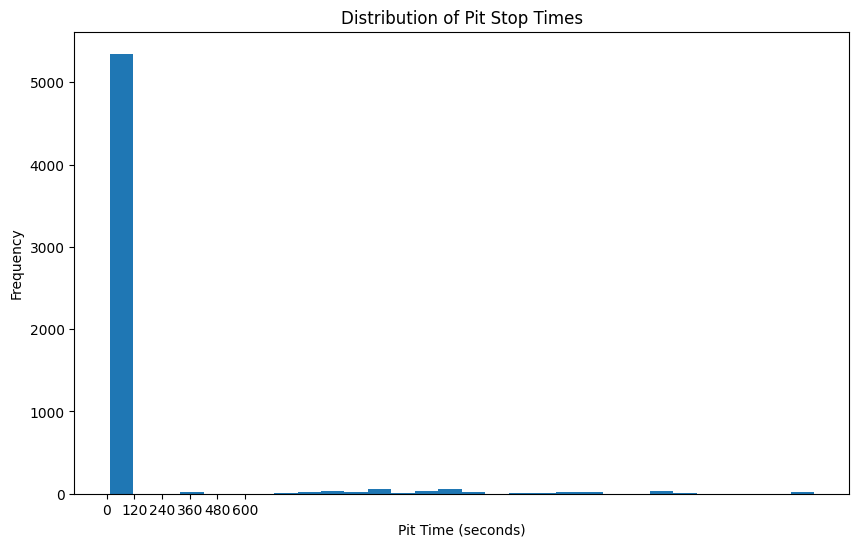

In [231]:
# Create histogram of pit times
plt.figure(figsize=(10, 6))
plt.hist(pit_stops['pits_time_seconds'], bins=30)
plt.xlabel('Pit Time (seconds)')
plt.ylabel('Frequency')
plt.title('Distribution of Pit Stop Times')
plt.xticks(range(0, 720, 120))
plt.show()

In [232]:
print(f"Old shape:\n{pit_stops.shape}")

# Remove pit stops that are over 120 sec
pit_stops_bound = pit_stops[pit_stops['pits_time_seconds'] <= 120]

print(f"New shape:\n{pit_stops_bound.shape}")

Old shape:
(5715, 7)
New shape:
(5346, 7)


### Aggregate

In [233]:
# Calculate rolling averages for pit times (last 5 and last 10 pits excluding current race)
pit_stops_sorted = pit_stops_bound.sort_values(['driver_id', 'race_id', 'stop_number'])

# Create a cumulative count of pit stops per driver
pit_stops_sorted['pit_count'] = pit_stops_sorted.groupby('driver_id').cumcount() + 1

# Calculate rolling averages for last 5 and last 10 pits (excluding current race)
pit_stops_sorted['avg_pit_time_last_5'] = pit_stops_sorted.groupby('driver_id')['pits_time_seconds']\
    .transform(lambda x: x.shift(1).rolling(window=5, min_periods=1).mean())
pit_stops_sorted['avg_pit_time_last_10'] = pit_stops_sorted.groupby('driver_id')['pits_time_seconds']\
    .transform(lambda x: x.shift(1).rolling(window=10, min_periods=1).mean())

# Aggregate to get max stop number and sum of pit times for current race
pit_stops_clean = pit_stops_sorted.groupby(['race_id', 'driver_id', 'team_id']).agg({
    'avg_pit_time_last_5': 'last',
    'avg_pit_time_last_10': 'last'
}).reset_index()

pit_stops_clean.tail()

,race_id,driver_id,team_id,avg_pit_time_last_5,avg_pit_time_last_10
3089,167,122,10,22.2144,24.1029
3090,167,123,15,19.9416,22.4437
3091,167,125,2,20.5508,23.6578
3092,167,126,17,20.8320,21.7064
3093,167,127,16,20.3330,22.0121


### Impute Missing Times

In [234]:
pit_stops_clean.isna().sum()

race_id                  0
driver_id                0
team_id                  0
avg_pit_time_last_5     24
avg_pit_time_last_10    24
dtype: int64

In [235]:
# Calculate team rolling averages for last 5 and last 10 pit stops
pit_stops_sorted['team_avg_pit_time_last_5'] = pit_stops_sorted.groupby(['team_id', 'race_id'])['pits_time_seconds']\
    .transform(lambda x: x.shift(1).rolling(window=5, min_periods=1).mean())
pit_stops_sorted['team_avg_pit_time_last_10'] = pit_stops_sorted.groupby(['team_id', 'race_id'])['pits_time_seconds']\
    .transform(lambda x: x.shift(1).rolling(window=10, min_periods=1).mean())

# Calculate overall averages
overall_avg_last_5 = pit_stops_sorted['pits_time_seconds'].mean()
overall_avg_last_10 = pit_stops_sorted['pits_time_seconds'].mean()

# Impute missing values. First try team average, then fall back to overall average
pit_stops_sorted['avg_pit_time_last_5'] = pit_stops_sorted['avg_pit_time_last_5'].fillna(
    pit_stops_sorted['team_avg_pit_time_last_5']
).fillna(overall_avg_last_5)

pit_stops_sorted['avg_pit_time_last_10'] = pit_stops_sorted['avg_pit_time_last_10'].fillna(
    pit_stops_sorted['team_avg_pit_time_last_10']
).fillna(overall_avg_last_10)

# Re-aggregate after imputation
pit_stops_clean = pit_stops_sorted.groupby(['race_id', 'driver_id', 'team_id']).agg({
    'avg_pit_time_last_5': 'last',
    'avg_pit_time_last_10': 'last'
}).reset_index()

pit_stops_clean.head()

,race_id,driver_id,team_id,avg_pit_time_last_5,avg_pit_time_last_10
0,1,6,1,24.837633,24.837633
1,1,12,4,24.837633,24.837633
2,1,57,2,24.837633,24.837633
3,1,60,1,21.421000,21.421000
4,1,67,10,24.837633,24.837633


In [236]:
pit_stops_clean.isna().sum()

race_id                 0
driver_id               0
team_id                 0
avg_pit_time_last_5     0
avg_pit_time_last_10    0
dtype: int64

### Drop Excess Column

In [237]:
pit_stops_clean.drop('team_id', axis=1, inplace=True)
pit_stops_clean.head()

,race_id,driver_id,avg_pit_time_last_5,avg_pit_time_last_10
0,1,6,24.837633,24.837633
1,1,12,24.837633,24.837633
2,1,57,24.837633,24.837633
3,1,60,21.421000,21.421000
4,1,67,24.837633,24.837633


### Save

In [238]:
pit_stops_clean.to_csv('../data/clean/pit_stops_clean.csv', index=False)

## Lap Results

### Load

In [180]:
laps = pd.read_csv('../data/raw/lap_results_raw.csv')

### Fill Unknown Race ID
70th anniversary race didn't get mapped to an ID

In [181]:
laps['race_id'] = laps['race_id'].replace('unknown', 47)
laps[laps['race_id'] == 'unknown']

,driver_name,driver_id,race_id,session,avg_pace_soft,std_pace_soft,laps_on_soft,deg_rate_soft,avg_pace_medium,std_pace_medium,laps_on_medium,deg_rate_medium,avg_pace_hard,std_pace_hard,laps_on_hard,deg_rate_hard,avg_pace_intermediate,std_pace_intermediate,laps_on_intermediate,deg_rate_intermediate,avg_pace_wet,std_pace_wet,laps_on_wet,deg_rate_wet


### Drop Missing Drivers
Some drivers werent mapped to an ID

Wasn't able to find their driver name/code on the Official F1 Results Website for each race and session, so dropping them seems reasonable here

In [182]:
laps[laps['driver_id'].isna()]

,driver_name,driver_id,race_id,session,avg_pace_soft,std_pace_soft,laps_on_soft,deg_rate_soft,avg_pace_medium,std_pace_medium,laps_on_medium,deg_rate_medium,avg_pace_hard,std_pace_hard,laps_on_hard,deg_rate_hard,avg_pace_intermediate,std_pace_intermediate,laps_on_intermediate,deg_rate_intermediate,avg_pace_wet,std_pace_wet,laps_on_wet,deg_rate_wet
4161,SCH,NaN,59,FP1,108.2930,7.192993,7,1.387431,NaN,NaN,0,NaN,113.291750,15.249515,4,2.871300,NaN,NaN,0,NaN,NaN,NaN,0,NaN
10483,COH,NaN,114,FP1,NaN,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN,0,NaN
10484,FOR,NaN,114,FP1,NaN,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN,0,NaN,114.0572,15.371328,5,4.952418,NaN,NaN,0,NaN
10485,GRA,NaN,114,FP1,NaN,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN,0,NaN,107.9650,6.045938,3,NaN,NaN,NaN,0,NaN
10486,MAN,NaN,114,FP1,NaN,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN,0,NaN
10488,MON,NaN,114,FP1,NaN,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN,0,NaN
10491,TBA,NaN,114,FP1,NaN,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN,0,NaN
10492,VIL,NaN,114,FP1,NaN,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN,0,NaN
14650,BAD,NaN,165,FP1,80.7845,0.092500,2,NaN,90.495857,19.764956,7,-0.901480,NaN,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN,0,NaN
14652,CAM,NaN,165,FP1,81.1720,0.000000,1,NaN,NaN,NaN,0,NaN,106.468556,26.523518,9,-0.875794,NaN,NaN,0,NaN,NaN,NaN,0,NaN


In [183]:
laps = laps.dropna(subset=['driver_id'])

### Drop Excess Columns

In [184]:
laps.drop(['driver_name', 'laps_on_soft', 'laps_on_medium', 'laps_on_hard', 'laps_on_intermediate', 'laps_on_wet'], axis=1, inplace=True)
laps_filtered = laps[laps['session'].isin(['FP1', 'FP2', 'FP3', 'Qualifying'])]
laps_filtered.head()

,driver_id,race_id,session,avg_pace_soft,std_pace_soft,deg_rate_soft,avg_pace_medium,std_pace_medium,deg_rate_medium,avg_pace_hard,std_pace_hard,deg_rate_hard,avg_pace_intermediate,std_pace_intermediate,deg_rate_intermediate,avg_pace_wet,std_pace_wet,deg_rate_wet
0,12.0,21,FP1,116.502286,15.501626,2.106637,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,83.0,21,FP1,111.926143,12.626743,0.158927,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,89.0,21,FP1,110.331444,12.705897,0.868236,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,104.0,21,FP1,114.511429,20.044373,1.953476,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,102.0,21,FP1,107.652636,11.337859,0.321741,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Add Boolean Flags

In [185]:
# Create boolean flags for each tyre compound
compounds = ['soft', 'medium', 'hard', 'intermediate', 'wet']

for c in compounds:
    flag_col = f'used_{c}'
    
    # Check if any of the pace metrics exist for this compound
    laps_filtered[flag_col] = (
        laps_filtered[f'avg_pace_{c}'].notna() |
        laps_filtered[f'deg_rate_{c}'].notna() |
        laps_filtered[f'std_pace_{c}'].notna()
        )
laps_filtered.head()

C:\Users\jackw\AppData\Local\Temp\ipykernel_4132\2591466057.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  laps_filtered[flag_col] = (
C:\Users\jackw\AppData\Local\Temp\ipykernel_4132\2591466057.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  laps_filtered[flag_col] = (
C:\Users\jackw\AppData\Local\Temp\ipykernel_4132\2591466057.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

,driver_id,race_id,session,avg_pace_soft,std_pace_soft,deg_rate_soft,avg_pace_medium,std_pace_medium,deg_rate_medium,avg_pace_hard,std_pace_hard,deg_rate_hard,avg_pace_intermediate,std_pace_intermediate,deg_rate_intermediate,avg_pace_wet,std_pace_wet,deg_rate_wet,used_soft,used_medium,used_hard,used_intermediate,used_wet
0,12.0,21,FP1,116.502286,15.501626,2.106637,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,False,False,False,False
1,83.0,21,FP1,111.926143,12.626743,0.158927,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,False,False,False,False
2,89.0,21,FP1,110.331444,12.705897,0.868236,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,False,False,False,False
3,104.0,21,FP1,114.511429,20.044373,1.953476,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,False,False,False,False
4,102.0,21,FP1,107.652636,11.337859,0.321741,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,False,False,False,False


In [186]:
laps_filtered.isna().sum()

driver_id                    0
race_id                      0
session                      0
avg_pace_soft             1461
std_pace_soft             1461
deg_rate_soft             4072
avg_pace_medium           7412
std_pace_medium           7412
deg_rate_medium           8247
avg_pace_hard            10209
std_pace_hard            10209
deg_rate_hard            10398
avg_pace_intermediate    11415
std_pace_intermediate    11415
deg_rate_intermediate    11732
avg_pace_wet             11865
std_pace_wet             11865
deg_rate_wet             12022
used_soft                    0
used_medium                  0
used_hard                    0
used_intermediate            0
used_wet                     0
dtype: int64

### Convert Long to Wide

In [187]:
# Pivot the filtered DataFrame to create separate columns for each session type
laps_pivot = laps_filtered.pivot_table(
    index=['race_id', 'driver_id'],
    columns='session',
    values=['avg_pace_soft', 'std_pace_soft', 'deg_rate_soft',
    'avg_pace_medium', 'std_pace_medium', 'deg_rate_medium',
    'avg_pace_hard', 'std_pace_hard', 'deg_rate_hard',
    'avg_pace_intermediate', 'std_pace_intermediate', 'deg_rate_intermediate',
    'avg_pace_wet', 'std_pace_wet', 'deg_rate_wet',
    'used_soft', 'used_medium', 'used_hard', 'used_intermediate', 'used_wet'],
    aggfunc='first'
)

# Flatten the multi-level column index
laps_pivot.columns = [f'{col[0]}_{col[1]}' for col in laps_pivot.columns]

# Reset index to make race_id and driver_id regular columns
laps_aggregated = laps_pivot.reset_index()

# Fill binary used columns with False indicating compound wasn't used
used_cols = [col for col in laps_aggregated.columns if col.startswith('used_')]
laps_aggregated[used_cols] = laps_aggregated[used_cols].fillna(False)

C:\Users\jackw\AppData\Local\Temp\ipykernel_4132\1559709627.py:22: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  laps_aggregated[used_cols] = laps_aggregated[used_cols].fillna(False)


In [188]:
laps_aggregated.head()

,race_id,driver_id,avg_pace_hard_FP1,avg_pace_hard_FP2,avg_pace_hard_FP3,avg_pace_hard_Qualifying,avg_pace_intermediate_FP1,avg_pace_intermediate_FP2,avg_pace_intermediate_FP3,avg_pace_intermediate_Qualifying,avg_pace_medium_FP1,avg_pace_medium_FP2,avg_pace_medium_FP3,avg_pace_medium_Qualifying,avg_pace_soft_FP1,avg_pace_soft_FP2,avg_pace_soft_FP3,avg_pace_soft_Qualifying,avg_pace_wet_FP1,avg_pace_wet_FP2,avg_pace_wet_FP3,avg_pace_wet_Qualifying,deg_rate_hard_FP1,deg_rate_hard_FP2,deg_rate_hard_FP3,deg_rate_hard_Qualifying,deg_rate_intermediate_FP1,deg_rate_intermediate_FP2,deg_rate_intermediate_FP3,deg_rate_intermediate_Qualifying,deg_rate_medium_FP1,deg_rate_medium_FP2,deg_rate_medium_FP3,deg_rate_medium_Qualifying,deg_rate_soft_FP1,deg_rate_soft_FP2,deg_rate_soft_FP3,deg_rate_soft_Qualifying,deg_rate_wet_FP1,deg_rate_wet_FP2,deg_rate_wet_FP3,deg_rate_wet_Qualifying,std_pace_hard_FP1,std_pace_hard_FP2,std_pace_hard_FP3,std_pace_hard_Qualifying,std_pace_intermediate_FP1,std_pace_intermediate_FP2,std_pace_intermediate_FP3,std_pace_intermediate_Qualifying,std_pace_medium_FP1,std_pace_medium_FP2,std_pace_medium_FP3,std_pace_medium_Qualifying,std_pace_soft_FP1,std_pace_soft_FP2,std_pace_soft_FP3,std_pace_soft_Qualifying,std_pace_wet_FP1,std_pace_wet_FP2,std_pace_wet_FP3,std_pace_wet_Qualifying,used_hard_FP1,used_hard_FP2,used_hard_FP3,used_hard_Qualifying,used_intermediate_FP1,used_intermediate_FP2,used_intermediate_FP3,used_intermediate_Qualifying,used_medium_FP1,used_medium_FP2,used_medium_FP3,used_medium_Qualifying,used_soft_FP1,used_soft_FP2,used_soft_FP3,used_soft_Qualifying,used_wet_FP1,used_wet_FP2,used_wet_FP3,used_wet_Qualifying
0,47,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,97.338909,NaN,NaN,99.898700,90.748750,104.222000,88.6555,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.386948,NaN,NaN,-0.788748,0.404828,4.337324,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.785024,NaN,NaN,16.464287,2.876662,22.241393,0.162500,NaN,NaN,NaN,NaN,False,False,False,False,False,False,False,False,False,True,False,False,True,True,True,True,False,False,False,False
1,47,56.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,104.887923,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.220903,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.645514,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False
2,47,57.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,91.397200,NaN,85.741500,88.152750,107.097000,107.635167,86.9790,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.731613,NaN,NaN,0.236917,NaN,1.933349,-0.042960,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.980735,NaN,0.524500,1.593473,29.705923,28.918398,1.070011,NaN,NaN,NaN,NaN,False,False,False,False,False,False,False,False,False,True,False,True,True,True,True,True,False,False,False,False
3,47,60.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,97.572111,103.1335,87.379000,114.579786,91.873444,97.547250,94.4982,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.584553,4.743371,NaN,1.160139,0.594390,3.089670,1.695088,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.257214,24.182489,0.000000,21.469646,2.495746,13.483413,13.419948,NaN,NaN,NaN,NaN,False,False,False,False,False,False,False,False,False,True,True,True,True,True,True,True,False,False,False,False
4,47,67.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,92.723250,NaN,88.153333,101.576125,87.656667,113.402400,87.8185,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.335610,NaN,NaN,0.449550,NaN,1.305425,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.429489,NaN,0.647152,20.944869,0.327258,25.355938,0.299500,NaN,NaN,NaN,NaN,False,False,False,False,False,False,False,False,False,True,False,True,True,True,True,True,False,False,False,False


In [189]:
laps_aggregated.shape

(3475, 82)

### Fill Missing Data

In [190]:
laps_aggregated.isna().sum()

race_id                                0
driver_id                              0
avg_pace_hard_FP1                   2376
avg_pace_hard_FP2                   2831
avg_pace_hard_FP3                   3305
avg_pace_hard_Qualifying            3430
avg_pace_intermediate_FP1           3306
avg_pace_intermediate_FP2           3374
avg_pace_intermediate_FP3           3236
avg_pace_intermediate_Qualifying    3232
avg_pace_medium_FP1                 1924
avg_pace_medium_FP2                 1511
avg_pace_medium_FP3                 2682
avg_pace_medium_Qualifying          3028
avg_pace_soft_FP1                    962
avg_pace_soft_FP2                    803
avg_pace_soft_FP3                   1017
avg_pace_soft_Qualifying             412
avg_pace_wet_FP1                    3414
avg_pace_wet_FP2                    3444
avg_pace_wet_FP3                    3370
avg_pace_wet_Qualifying             3370
deg_rate_hard_FP1                   2461
deg_rate_hard_FP2                   2883
deg_rate_hard_FP

In [191]:
sessions = ['FP1', 'FP2', 'FP3', 'Qualifying']
compounds = ['soft', 'medium', 'hard', 'intermediate', 'wet']

# Fill missing values for each compound and session with 0
for s in sessions:
    for c in compounds:
        laps_aggregated[f'avg_pace_{c}_{s}'] = laps_aggregated[f'avg_pace_{c}_{s}'].fillna(0)
        laps_aggregated[f'std_pace_{c}_{s}'] = laps_aggregated[f'std_pace_{c}_{s}'].fillna(0)
        laps_aggregated[f'deg_rate_{c}_{s}'] = laps_aggregated[f'deg_rate_{c}_{s}'].fillna(0)

In [192]:
laps_aggregated.isna().sum()

race_id                             0
driver_id                           0
avg_pace_hard_FP1                   0
avg_pace_hard_FP2                   0
avg_pace_hard_FP3                   0
avg_pace_hard_Qualifying            0
avg_pace_intermediate_FP1           0
avg_pace_intermediate_FP2           0
avg_pace_intermediate_FP3           0
avg_pace_intermediate_Qualifying    0
avg_pace_medium_FP1                 0
avg_pace_medium_FP2                 0
avg_pace_medium_FP3                 0
avg_pace_medium_Qualifying          0
avg_pace_soft_FP1                   0
avg_pace_soft_FP2                   0
avg_pace_soft_FP3                   0
avg_pace_soft_Qualifying            0
avg_pace_wet_FP1                    0
avg_pace_wet_FP2                    0
avg_pace_wet_FP3                    0
avg_pace_wet_Qualifying             0
deg_rate_hard_FP1                   0
deg_rate_hard_FP2                   0
deg_rate_hard_FP3                   0
deg_rate_hard_Qualifying            0
deg_rate_int

In [193]:
laps_aggregated.head(20)

,race_id,driver_id,avg_pace_hard_FP1,avg_pace_hard_FP2,avg_pace_hard_FP3,avg_pace_hard_Qualifying,avg_pace_intermediate_FP1,avg_pace_intermediate_FP2,avg_pace_intermediate_FP3,avg_pace_intermediate_Qualifying,avg_pace_medium_FP1,avg_pace_medium_FP2,avg_pace_medium_FP3,avg_pace_medium_Qualifying,avg_pace_soft_FP1,avg_pace_soft_FP2,avg_pace_soft_FP3,avg_pace_soft_Qualifying,avg_pace_wet_FP1,avg_pace_wet_FP2,avg_pace_wet_FP3,avg_pace_wet_Qualifying,deg_rate_hard_FP1,deg_rate_hard_FP2,deg_rate_hard_FP3,deg_rate_hard_Qualifying,deg_rate_intermediate_FP1,deg_rate_intermediate_FP2,deg_rate_intermediate_FP3,deg_rate_intermediate_Qualifying,deg_rate_medium_FP1,deg_rate_medium_FP2,deg_rate_medium_FP3,deg_rate_medium_Qualifying,deg_rate_soft_FP1,deg_rate_soft_FP2,deg_rate_soft_FP3,deg_rate_soft_Qualifying,deg_rate_wet_FP1,deg_rate_wet_FP2,deg_rate_wet_FP3,deg_rate_wet_Qualifying,std_pace_hard_FP1,std_pace_hard_FP2,std_pace_hard_FP3,std_pace_hard_Qualifying,std_pace_intermediate_FP1,std_pace_intermediate_FP2,std_pace_intermediate_FP3,std_pace_intermediate_Qualifying,std_pace_medium_FP1,std_pace_medium_FP2,std_pace_medium_FP3,std_pace_medium_Qualifying,std_pace_soft_FP1,std_pace_soft_FP2,std_pace_soft_FP3,std_pace_soft_Qualifying,std_pace_wet_FP1,std_pace_wet_FP2,std_pace_wet_FP3,std_pace_wet_Qualifying,used_hard_FP1,used_hard_FP2,used_hard_FP3,used_hard_Qualifying,used_intermediate_FP1,used_intermediate_FP2,used_intermediate_FP3,used_intermediate_Qualifying,used_medium_FP1,used_medium_FP2,used_medium_FP3,used_medium_Qualifying,used_soft_FP1,used_soft_FP2,used_soft_FP3,used_soft_Qualifying,used_wet_FP1,used_wet_FP2,used_wet_FP3,used_wet_Qualifying
0,47,6.0,0.0,0.000000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,97.338909,0.0000,0.000000,99.898700,90.748750,104.222000,88.65550,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.386948,0.000000,0.0,-0.788748,0.404828,4.337324,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.785024,0.000000,0.000000,16.464287,2.876662,22.241393,0.162500,0.0,0.0,0.0,0.0,False,False,False,False,False,False,False,False,False,True,False,False,True,True,True,True,False,False,False,False
1,47,56.0,0.0,0.000000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0000,0.000000,104.887923,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,-0.220903,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,21.645514,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False
2,47,57.0,0.0,0.000000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,91.397200,0.0000,85.741500,88.152750,107.097000,107.635167,86.97900,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.731613,0.000000,0.0,0.236917,0.000000,1.933349,-0.042960,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.980735,0.000000,0.524500,1.593473,29.705923,28.918398,1.070011,0.0,0.0,0.0,0.0,False,False,False,False,False,False,False,False,False,True,False,True,True,True,True,True,False,False,False,False
3,47,60.0,0.0,0.000000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,97.572111,103.1335,87.379000,114.579786,91.873444,97.547250,94.49820,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.584553,4.743371,0.0,1.160139,0.594390,3.089670,1.695088,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.257214,24.182489,0.000000,21.469646,2.495746,13.483413,13.419948,0.0,0.0,0.0,0.0,False,False,False,False,False,False,False,False,False,True,True,True,True,True,True,True,False,False,False,False
4,47,67.0,0.0,0.000000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,92.723250,0.0000,88.153333,101.576125,87.656667,113.402400,87.81850,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.335610,0.000000,0.0,0.449550,0.000000,1.305425,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.429489,0.000000,0.647152,20.944869,0.327258,25.355938,0.299500,0.0,0.0,0.0,0.0,False,

### Correct DataTypes

In [194]:
print(f"Previous DataTypes:\n{laps_aggregated.dtypes}")

laps_aggregated['race_id'] = laps_aggregated['race_id'].astype(int)
laps_aggregated['driver_id'] = laps_aggregated['driver_id'].astype(int)

print(f"\nNew DataTypes:\n{laps_aggregated.dtypes}")
display(laps_aggregated.head())

Previous DataTypes:
race_id                              object
driver_id                           float64
avg_pace_hard_FP1                   float64
avg_pace_hard_FP2                   float64
avg_pace_hard_FP3                   float64
avg_pace_hard_Qualifying            float64
avg_pace_intermediate_FP1           float64
avg_pace_intermediate_FP2           float64
avg_pace_intermediate_FP3           float64
avg_pace_intermediate_Qualifying    float64
avg_pace_medium_FP1                 float64
avg_pace_medium_FP2                 float64
avg_pace_medium_FP3                 float64
avg_pace_medium_Qualifying          float64
avg_pace_soft_FP1                   float64
avg_pace_soft_FP2                   float64
avg_pace_soft_FP3                   float64
avg_pace_soft_Qualifying            float64
avg_pace_wet_FP1                    float64
avg_pace_wet_FP2                    float64
avg_pace_wet_FP3                    float64
avg_pace_wet_Qualifying             float64
deg_rate_har

,race_id,driver_id,avg_pace_hard_FP1,avg_pace_hard_FP2,avg_pace_hard_FP3,avg_pace_hard_Qualifying,avg_pace_intermediate_FP1,avg_pace_intermediate_FP2,avg_pace_intermediate_FP3,avg_pace_intermediate_Qualifying,avg_pace_medium_FP1,avg_pace_medium_FP2,avg_pace_medium_FP3,avg_pace_medium_Qualifying,avg_pace_soft_FP1,avg_pace_soft_FP2,avg_pace_soft_FP3,avg_pace_soft_Qualifying,avg_pace_wet_FP1,avg_pace_wet_FP2,avg_pace_wet_FP3,avg_pace_wet_Qualifying,deg_rate_hard_FP1,deg_rate_hard_FP2,deg_rate_hard_FP3,deg_rate_hard_Qualifying,deg_rate_intermediate_FP1,deg_rate_intermediate_FP2,deg_rate_intermediate_FP3,deg_rate_intermediate_Qualifying,deg_rate_medium_FP1,deg_rate_medium_FP2,deg_rate_medium_FP3,deg_rate_medium_Qualifying,deg_rate_soft_FP1,deg_rate_soft_FP2,deg_rate_soft_FP3,deg_rate_soft_Qualifying,deg_rate_wet_FP1,deg_rate_wet_FP2,deg_rate_wet_FP3,deg_rate_wet_Qualifying,std_pace_hard_FP1,std_pace_hard_FP2,std_pace_hard_FP3,std_pace_hard_Qualifying,std_pace_intermediate_FP1,std_pace_intermediate_FP2,std_pace_intermediate_FP3,std_pace_intermediate_Qualifying,std_pace_medium_FP1,std_pace_medium_FP2,std_pace_medium_FP3,std_pace_medium_Qualifying,std_pace_soft_FP1,std_pace_soft_FP2,std_pace_soft_FP3,std_pace_soft_Qualifying,std_pace_wet_FP1,std_pace_wet_FP2,std_pace_wet_FP3,std_pace_wet_Qualifying,used_hard_FP1,used_hard_FP2,used_hard_FP3,used_hard_Qualifying,used_intermediate_FP1,used_intermediate_FP2,used_intermediate_FP3,used_intermediate_Qualifying,used_medium_FP1,used_medium_FP2,used_medium_FP3,used_medium_Qualifying,used_soft_FP1,used_soft_FP2,used_soft_FP3,used_soft_Qualifying,used_wet_FP1,used_wet_FP2,used_wet_FP3,used_wet_Qualifying
0,47,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,97.338909,0.0000,0.000000,99.898700,90.748750,104.222000,88.6555,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.386948,0.000000,0.0,-0.788748,0.404828,4.337324,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.785024,0.000000,0.000000,16.464287,2.876662,22.241393,0.162500,0.0,0.0,0.0,0.0,False,False,False,False,False,False,False,False,False,True,False,False,True,True,True,True,False,False,False,False
1,47,56,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0000,0.000000,104.887923,0.000000,0.000000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,-0.220903,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,21.645514,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False
2,47,57,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,91.397200,0.0000,85.741500,88.152750,107.097000,107.635167,86.9790,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.731613,0.000000,0.0,0.236917,0.000000,1.933349,-0.042960,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.980735,0.000000,0.524500,1.593473,29.705923,28.918398,1.070011,0.0,0.0,0.0,0.0,False,False,False,False,False,False,False,False,False,True,False,True,True,True,True,True,False,False,False,False
3,47,60,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,97.572111,103.1335,87.379000,114.579786,91.873444,97.547250,94.4982,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.584553,4.743371,0.0,1.160139,0.594390,3.089670,1.695088,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.257214,24.182489,0.000000,21.469646,2.495746,13.483413,13.419948,0.0,0.0,0.0,0.0,False,False,False,False,False,False,False,False,False,True,True,True,True,True,True,True,False,False,False,False
4,47,67,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,92.723250,0.0000,88.153333,101.576125,87.656667,113.402400,87.8185,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.335610,0.000000,0.0,0.449550,0.000000,1.305425,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.429489,0.000000,0.647152,20.944869,0.327258,25.355938,0.299500,0.0,0.0,0.0,0.0,False,False,False,False,False,False,False,False,False,True,False,True,True,True,True,True,False,False,Fals

### Save

In [195]:
laps_aggregated.to_csv('../data/clean/laps_clean.csv', index=False)

## Weather

### Load

In [293]:
weather = pd.read_csv('../data/raw/weather_results_raw.csv')

### Fill Unknown Race ID
70th anniversary race didn't get mapped to an ID

In [294]:
weather['race_id'] = weather['race_id'].replace('unknown', 47)
weather[weather['race_id'] == 'unknown']

,AirTemp_mean,AirTemp_min,AirTemp_max,AirTemp_std,TrackTemp_mean,TrackTemp_min,TrackTemp_max,TrackTemp_std,WindSpeed_mean,WindSpeed_min,WindSpeed_max,WindSpeed_std,Humidity_mean,Humidity_min,Humidity_max,Humidity_std,Pressure_mean,Pressure_min,Pressure_max,Pressure_std,Rainfall_any,Rainfall_mean,race_id,session


### Filter Data

In [295]:
# Filter for FP3 weather data
weather_fp3 = weather[weather['session'] == 'FP3']
display(weather_fp3.head())

# Filter for Qualifying weather data
weather_qualifying = weather[weather['session'] == 'Qualifying']
display(weather_qualifying.head())

,AirTemp_mean,AirTemp_min,AirTemp_max,AirTemp_std,TrackTemp_mean,TrackTemp_min,TrackTemp_max,TrackTemp_std,WindSpeed_mean,WindSpeed_min,WindSpeed_max,WindSpeed_std,Humidity_mean,Humidity_min,Humidity_max,Humidity_std,Pressure_mean,Pressure_min,Pressure_max,Pressure_std,Rainfall_any,Rainfall_mean,race_id,session
2,31.860976,31.0,32.2,0.290914,39.571951,36.9,44.4,2.304653,1.602439,0.0,3.0,0.707626,29.797561,29.0,30.8,0.405510,1015.898780,1015.5,1016.4,0.218012,False,0.000000,21,FP3
7,19.772059,18.6,21.0,0.540549,24.758824,22.2,28.3,1.247713,0.754412,0.0,1.3,0.272870,86.838235,81.2,92.3,3.268257,1010.220588,1009.6,1011.5,0.523923,True,0.220588,1,FP3
12,22.310000,21.6,23.3,0.482791,30.990000,29.6,35.2,1.409301,1.054286,0.0,2.2,0.501501,63.778571,58.7,68.5,3.138351,934.348571,934.2,934.6,0.111307,True,0.228571,9,FP3
17,24.032836,23.5,24.5,0.238294,29.402985,28.3,30.5,0.624978,1.407463,0.6,2.5,0.490613,41.446269,40.2,43.2,0.799115,1015.383582,1015.0,1016.0,0.318898,True,0.179104,4,FP3
22,29.482090,28.7,30.2,0.380560,37.723881,35.8,41.4,1.642346,0.892537,0.3,1.7,0.334987,44.008955,40.8,45.7,1.265358,1008.401493,1008.2,1008.6,0.092920,False,0.000000,2,FP3


,AirTemp_mean,AirTemp_min,AirTemp_max,AirTemp_std,TrackTemp_mean,TrackTemp_min,TrackTemp_max,TrackTemp_std,WindSpeed_mean,WindSpeed_min,WindSpeed_max,WindSpeed_std,Humidity_mean,Humidity_min,Humidity_max,Humidity_std,Pressure_mean,Pressure_min,Pressure_max,Pressure_std,Rainfall_any,Rainfall_mean,race_id,session
3,28.651282,28.3,29.1,0.171883,31.774359,30.7,33.1,0.704427,1.712821,0.6,2.8,0.461887,46.692308,41.7,48.7,1.629578,1016.453846,1016.2,1016.7,1.500583e-01,False,0.000000,21,Qualifying
8,24.737179,24.2,25.2,0.202009,30.473077,28.8,32.6,1.013246,0.775641,0.0,2.1,0.463523,60.556410,57.2,63.5,1.685507,1007.900000,1007.9,1007.9,5.721134e-13,False,0.000000,1,Qualifying
13,24.869697,24.2,25.7,0.343722,33.492424,31.4,36.8,1.362838,1.192424,0.0,2.9,0.650517,41.353030,37.0,48.2,2.628789,933.733333,933.6,933.9,1.042679e-01,True,0.090909,9,Qualifying
18,22.658824,22.0,23.0,0.243871,26.561765,26.0,27.1,0.351979,1.610294,0.6,3.2,0.477600,46.213235,45.4,47.4,0.484354,1015.147059,1014.9,1015.4,1.028992e-01,True,0.073529,4,Qualifying
23,28.214474,27.8,28.8,0.235346,31.864474,31.4,32.5,0.318205,0.718421,0.0,1.6,0.355044,43.017105,34.8,47.6,4.649283,1008.692105,1008.5,1008.8,7.073548e-02,False,0.000000,2,Qualifying


### Correct DataTypes

In [296]:
weather_fp3['race_id'] = weather_fp3['race_id'].astype(int)
weather_qualifying['race_id'] = weather_qualifying['race_id'].astype(int)

C:\Users\jackw\AppData\Local\Temp\ipykernel_4132\2102488542.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather_fp3['race_id'] = weather_fp3['race_id'].astype(int)
C:\Users\jackw\AppData\Local\Temp\ipykernel_4132\2102488542.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather_qualifying['race_id'] = weather_qualifying['race_id'].astype(int)


### Drop Excess Column

In [297]:
print(f"FP3 shape before: {weather_fp3.shape}")
print(f"Qualifying shape before: {weather_qualifying.shape}\n")

weather_fp3.drop('session', axis=1, inplace=True)
weather_qualifying.drop('session', axis=1, inplace=True)

print(f"FP3 shape after: {weather_fp3.shape}")
print(f"Qualifying shape after: {weather_qualifying.shape}")

FP3 shape before: (141, 24)
Qualifying shape before: (167, 24)

FP3 shape after: (141, 23)
Qualifying shape after: (167, 23)


C:\Users\jackw\AppData\Local\Temp\ipykernel_4132\2174609698.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather_fp3.drop('session', axis=1, inplace=True)
C:\Users\jackw\AppData\Local\Temp\ipykernel_4132\2174609698.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather_qualifying.drop('session', axis=1, inplace=True)


In [298]:
display(weather_fp3.head())
display(weather_qualifying.head())

,AirTemp_mean,AirTemp_min,AirTemp_max,AirTemp_std,TrackTemp_mean,TrackTemp_min,TrackTemp_max,TrackTemp_std,WindSpeed_mean,WindSpeed_min,WindSpeed_max,WindSpeed_std,Humidity_mean,Humidity_min,Humidity_max,Humidity_std,Pressure_mean,Pressure_min,Pressure_max,Pressure_std,Rainfall_any,Rainfall_mean,race_id
2,31.860976,31.0,32.2,0.290914,39.571951,36.9,44.4,2.304653,1.602439,0.0,3.0,0.707626,29.797561,29.0,30.8,0.405510,1015.898780,1015.5,1016.4,0.218012,False,0.000000,21
7,19.772059,18.6,21.0,0.540549,24.758824,22.2,28.3,1.247713,0.754412,0.0,1.3,0.272870,86.838235,81.2,92.3,3.268257,1010.220588,1009.6,1011.5,0.523923,True,0.220588,1
12,22.310000,21.6,23.3,0.482791,30.990000,29.6,35.2,1.409301,1.054286,0.0,2.2,0.501501,63.778571,58.7,68.5,3.138351,934.348571,934.2,934.6,0.111307,True,0.228571,9
17,24.032836,23.5,24.5,0.238294,29.402985,28.3,30.5,0.624978,1.407463,0.6,2.5,0.490613,41.446269,40.2,43.2,0.799115,1015.383582,1015.0,1016.0,0.318898,True,0.179104,4
22,29.482090,28.7,30.2,0.380560,37.723881,35.8,41.4,1.642346,0.892537,0.3,1.7,0.334987,44.008955,40.8,45.7,1.265358,1008.401493,1008.2,1008.6,0.092920,False,0.000000,2


,AirTemp_mean,AirTemp_min,AirTemp_max,AirTemp_std,TrackTemp_mean,TrackTemp_min,TrackTemp_max,TrackTemp_std,WindSpeed_mean,WindSpeed_min,WindSpeed_max,WindSpeed_std,Humidity_mean,Humidity_min,Humidity_max,Humidity_std,Pressure_mean,Pressure_min,Pressure_max,Pressure_std,Rainfall_any,Rainfall_mean,race_id
3,28.651282,28.3,29.1,0.171883,31.774359,30.7,33.1,0.704427,1.712821,0.6,2.8,0.461887,46.692308,41.7,48.7,1.629578,1016.453846,1016.2,1016.7,1.500583e-01,False,0.000000,21
8,24.737179,24.2,25.2,0.202009,30.473077,28.8,32.6,1.013246,0.775641,0.0,2.1,0.463523,60.556410,57.2,63.5,1.685507,1007.900000,1007.9,1007.9,5.721134e-13,False,0.000000,1
13,24.869697,24.2,25.7,0.343722,33.492424,31.4,36.8,1.362838,1.192424,0.0,2.9,0.650517,41.353030,37.0,48.2,2.628789,933.733333,933.6,933.9,1.042679e-01,True,0.090909,9
18,22.658824,22.0,23.0,0.243871,26.561765,26.0,27.1,0.351979,1.610294,0.6,3.2,0.477600,46.213235,45.4,47.4,0.484354,1015.147059,1014.9,1015.4,1.028992e-01,True,0.073529,4
23,28.214474,27.8,28.8,0.235346,31.864474,31.4,32.5,0.318205,0.718421,0.0,1.6,0.355044,43.017105,34.8,47.6,4.649283,1008.692105,1008.5,1008.8,7.073548e-02,False,0.000000,2


### Save

In [299]:
weather_fp3.to_csv('../data/clean/weather_fp3_clean.csv', index=False)
weather_qualifying.to_csv('../data/clean/weather_qualifying_clean.csv', index=False)

## Flag Results

### Load

In [155]:
flags = pd.read_csv('../data/raw/flag_results_raw.csv')

### Fill Unknown Race ID
70th anniversary race didn't get mapped to an ID

In [156]:
flags['race_id'] = flags['race_id'].replace('unknown', 47)
flags[flags['race_id'] == 'unknown']

,flag_yellow_count,flag_double_yellow_count,flag_red_count,flag_clear_count,safety_car_deployments,virtual_safety_car_deployments,race_id,session,total_sc_laps,total_vsc_laps


### Filter Data

In [157]:
# Filter for only race data
flags_filtered = flags[flags['session'] == 'Race']
flags_filtered.head()

,flag_yellow_count,flag_double_yellow_count,flag_red_count,flag_clear_count,safety_car_deployments,virtual_safety_car_deployments,race_id,session,total_sc_laps,total_vsc_laps
4,6,5,0,12,1,1,21,Race,4.0,2.0
9,9,5,0,11,1,1,1,Race,4.0,0.0
14,8,7,0,15,0,1,9,Race,0.0,2.0
19,12,10,0,22,2,0,4,Race,13.0,0.0
24,5,10,0,15,0,1,2,Race,0.0,3.0


### Add Circuit ID

In [158]:
races_2018 = pd.read_csv('../data/clean/race_results_clean_2018+.csv')
races_2018 = races_2018[['race_id', 'circuit_id']].drop_duplicates()
races_2018.head()

,race_id,circuit_id
0,1,1
20,2,2
40,3,3
60,4,4
80,5,5


In [159]:
flags_filtered['race_id'] = flags_filtered['race_id'].astype(int)
flags_filtered = flags_filtered.merge(races_2018, on='race_id', how='inner')
flags_filtered.head()

C:\Users\jackw\AppData\Local\Temp\ipykernel_8676\2807641751.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flags_filtered['race_id'] = flags_filtered['race_id'].astype(int)


,flag_yellow_count,flag_double_yellow_count,flag_red_count,flag_clear_count,safety_car_deployments,virtual_safety_car_deployments,race_id,session,total_sc_laps,total_vsc_laps,circuit_id
0,6,5,0,12,1,1,21,Race,4.0,2.0,21
1,9,5,0,11,1,1,1,Race,4.0,0.0,1
2,8,7,0,15,0,1,9,Race,0.0,2.0,9
3,12,10,0,22,2,0,4,Race,13.0,0.0,4
4,5,10,0,15,0,1,2,Race,0.0,3.0,2


In [160]:
flags_filtered.shape

(167, 11)

### Aggregate

In [ ]:
# Sort by race_id
flags_sorted = flags_filtered.sort_values('race_id')

# Initialize lists
race_ids = []
circuit_ids = []
yellow_flag_probs = []
double_yellow_probs = []
red_flag_probs = []
safety_car_probs = []
vsc_probs = []
avg_yellow_counts = []
avg_double_yellow_counts = []
avg_red_counts = []
avg_safety_car_deployments = []
avg_vsc_deployments = []
avg_sc_laps = []
avg_vsc_laps = []

# Bayesian smoothing parameter
k = 1

# For each circuit, calculate probabilities and averages using historical data
for circuit_id in flags_sorted['circuit_id'].unique():
    circuit_data = flags_sorted[flags_sorted['circuit_id'] == circuit_id].sort_values('race_id')
    
    # For each race at this circuit, use data from previous races only to avoid leakage
    for i, (race_id, race_data) in enumerate(circuit_data.groupby('race_id')):
        
        # Get all races before current race at this circuit
        historical_data = circuit_data[circuit_data['race_id'] < race_id]
        
        # Store race_id and circuit_id for this specific prediction
        race_ids.append(race_id)
        circuit_ids.append(circuit_id)
        
        if len(historical_data) == 0:
            
            # First race at this circuit, will be filled with global stats later
            yellow_flag_probs.append(None)
            double_yellow_probs.append(None)
            red_flag_probs.append(None)
            safety_car_probs.append(None)
            vsc_probs.append(None)
            avg_yellow_counts.append(None)
            avg_double_yellow_counts.append(None)
            avg_red_counts.append(None)
            avg_safety_car_deployments.append(None)
            avg_vsc_deployments.append(None)
            avg_sc_laps.append(None)
            avg_vsc_laps.append(None)
        
        else:
            # Calculate probabilities with Bayesian smoothing
            total_races = len(historical_data)
            
            # Yellow flag probability
            yellow_races = len(historical_data[historical_data['flag_yellow_count'] > 0])
            yellow_flag_probs.append((yellow_races + k) / (total_races + 2*k))
            
            # Double yellow probability
            double_yellow_races = len(historical_data[historical_data['flag_double_yellow_count'] > 0])
            double_yellow_probs.append((double_yellow_races + k) / (total_races + 2*k))
            
            # Red flag probability
            red_races = len(historical_data[historical_data['flag_red_count'] > 0])
            red_flag_probs.append((red_races + k) / (total_races + 2*k))
            
            # Safety car probability
            sc_races = len(historical_data[historical_data['safety_car_deployments'] > 0])
            safety_car_probs.append((sc_races + k) / (total_races + 2*k))
            
            # VSC probability
            vsc_races = len(historical_data[historical_data['virtual_safety_car_deployments'] > 0])
            vsc_probs.append((vsc_races + k) / (total_races + 2*k))
            
            # Averages
            avg_yellow_counts.append(historical_data['flag_yellow_count'].mean())
            avg_double_yellow_counts.append(historical_data['flag_double_yellow_count'].mean())
            avg_red_counts.append(historical_data['flag_red_count'].mean())
            avg_safety_car_deployments.append(historical_data['safety_car_deployments'].mean())
            avg_vsc_deployments.append(historical_data['virtual_safety_car_deployments'].mean())
            avg_sc_laps.append(historical_data['total_sc_laps'].mean())
            avg_vsc_laps.append(historical_data['total_vsc_laps'].mean())

# Create summary
circuit_flag_stats = pd.DataFrame({
    'race_id': race_ids,
    'circuit_id': circuit_ids,
    'yellow_flag_prob': yellow_flag_probs,
    'double_yellow_prob': double_yellow_probs,
    'red_flag_prob': red_flag_probs,
    'safety_car_prob': safety_car_probs,
    'vsc_prob': vsc_probs,
    'avg_yellow_count': avg_yellow_counts,
    'avg_double_yellow_count': avg_double_yellow_counts,
    'avg_red_count': avg_red_counts,
    'avg_safety_car_deployments': avg_safety_car_deployments,
    'avg_vsc_deployments': avg_vsc_deployments,
    'avg_sc_laps': avg_sc_laps,
    'avg_vsc_laps': avg_vsc_laps
})

# Calculate global stats for imputation
global_stats = {
    'yellow_flag_prob': (flags_sorted['flag_yellow_count'] > 0).mean(),
    'double_yellow_prob': (flags_sorted['flag_double_yellow_count'] > 0).mean(),
    'red_flag_prob': (flags_sorted['flag_red_count'] > 0).mean(),
    'safety_car_prob': (flags_sorted['safety_car_deployments'] > 0).mean(),
    'vsc_prob': (flags_sorted['virtual_safety_car_deployments'] > 0).mean(),
    'avg_yellow_count': flags_sorted['flag_yellow_count'].mean(),
    'avg_double_yellow_count': flags_sorted['flag_double_yellow_count'].mean(),
    'avg_red_count': flags_sorted['flag_red_count'].mean(),
    'avg_safety_car_deployments': flags_sorted['safety_car_deployments'].mean(),
    'avg_vsc_deployments': flags_sorted['virtual_safety_car_deployments'].mean(),
    'avg_sc_laps': flags_sorted['total_sc_laps'].mean(),
    'avg_vsc_laps': flags_sorted['total_vsc_laps'].mean(),
}

# Fill missing values with global stast
for col in global_stats.keys():
    circuit_flag_stats[col] = circuit_flag_stats[col].fillna(global_stats[col])

circuit_flag_stats.head()

,race_id,circuit_id,yellow_flag_prob,double_yellow_prob,red_flag_prob,safety_car_prob,vsc_prob,avg_yellow_count,avg_double_yellow_count,avg_red_count,avg_safety_car_deployments,avg_vsc_deployments,avg_sc_laps,avg_vsc_laps
0,1,1,0.904192,0.814371,0.119760,0.562874,0.413174,4.095808,3.538922,0.161677,0.784431,0.54491,3.065868,1.221557
1,22,1,0.666667,0.666667,0.333333,0.666667,0.666667,9.000000,5.000000,0.000000,1.000000,1.00000,4.000000,0.000000
2,84,1,0.750000,0.500000,0.250000,0.500000,0.500000,5.500000,2.500000,0.000000,0.500000,0.50000,2.000000,0.000000
3,106,1,0.800000,0.600000,0.200000,0.600000,0.600000,4.666667,3.333333,0.000000,1.000000,1.00000,4.000000,12.666667
4,128,1,0.833333,0.666667,0.333333,0.666667,0.666667,5.500000,3.500000,1.000000,1.500000,1.00000,3.750000,10.000000


### Save

In [162]:
circuit_flag_stats.to_csv('../data/clean/flags_clean.csv', index=False)

## Circuits

### Load

In [23]:
circuits = pd.read_csv('../data/raw/circuits_raw.csv')

### Separate Bahrain Outer Circuit

In [24]:
# Create a dictionary with Sakhir Outer Circuit (2020) data
new_circuit_data = {
    'name': 'Bahrain International Outer Circuit',
    'type': 'Race circuit',
    'direction': 'Clockwise',
    'location': 'Sakhir',
    'country': 'Bahrain',
    'length': '3.543 km (2.202 mi)',
    'turns': '11',
    'gp': 'Sakhir Grand Prix',
    'seasons': '2020',
    'gps_held': '1'
}

# Convert to DataFrame and append to existing data
new_row = pd.DataFrame([new_circuit_data])
circuits = pd.concat([circuits, new_row], ignore_index=True)

circuits.tail(3)

,name,type,direction,location,country,length,turns,gp,seasons,gps_held
76,Yas Marina Circuit *,Race circuit,Anti-clockwise,Abu Dhabi,United Arab Emirates,5.281 km (3.281 mi),15,Abu Dhabi Grand Prix,2009–2024,16
77,Zeltweg Airfield,Road circuit,Clockwise,Zeltweg,Austria,3.186 km (1.980 mi),4,Austrian Grand Prix,1964,1
78,Bahrain International Outer Circuit,Race circuit,Clockwise,Sakhir,Bahrain,3.543 km (2.202 mi),11,Sakhir Grand Prix,2020,1


### Filter for 2018+ Seasons

In [25]:
circuits = circuits.dropna(subset=['seasons'])

def has_year_after_2018(season_str, target_start=2018):
    # Split by comma to handle multiple ranges
    ranges = season_str.split(',')
    
    for range_part in ranges:
        range_part = range_part.strip()
        
        # Clean the string
        range_part = range_part.replace(' ', '').replace('[', '').replace(']', '').replace('c', '').replace('e', '')
        
        # Check if it's a range
        if '–' in range_part:
            end_year = int(range_part.split('–')[-1])
        else:
            # Single year with no range
            end_year = int(range_part)
        
        # Check if this range includes any year from 2018 onward
        if end_year >= target_start:
            return True
    
    return False

circuits = circuits[circuits['seasons'].apply(has_year_after_2018)]
print(f"{circuits.shape[0]} rows left in the filtered dataframe")

32 rows left in the filtered dataframe


### Add circuit_id Column

In [26]:
# Load circuit_id mapping dictionary
circuit_id_map = load_id_map('../data/raw/circuit_id_map.pkl')

def find_circuit_info(gp_str, country_str, id_map):
    # Clean the GP string
    cleaned_gp = gp_str.replace("Grand Prix", "").replace("\n", "").strip()
    
    # Split on commas if present
    gp_parts = [part.strip() for part in cleaned_gp.split(',')] if ',' in cleaned_gp else [cleaned_gp]
    
    # Try to match each part with circuit_id dictionary keys
    for part in gp_parts:
        for key in id_map.keys():
            if part.lower() in key.lower() or key.lower() in part.lower():
                return id_map[key], key
    
    # If no match found in GP parts, try to match with country
    for key in id_map.keys():
        if country_str.lower() in key.lower() or key.lower() in country_str.lower():
            return id_map[key], key
    
    # If still no match found
    return "no match", "no match"

# Apply the function to create circuit_id and circuit_name columns
circuits[['circuit_id', 'circuit_name']] = circuits.apply(
    lambda row: pd.Series(find_circuit_info(row['gp'], row['country'], circuit_id_map)), 
    axis=1
)

circuits

,name,type,direction,location,country,length,turns,gp,seasons,gps_held,circuit_id,circuit_name
3,Albert Park Circuit *,Street circuit,Clockwise,Melbourne,Australia,5.278 km (3.280 mi),14,Australian Grand Prix,"1996–2019, 2022–2025",28,1,Australia
4,Algarve International Circuit,Race circuit,Clockwise,Portimão,Portugal,4.653 km (2.891 mi),15,Portuguese Grand Prix,2020–2021,2,26,Portugal
6,Autódromo Hermanos Rodríguez *,Race circuit,Clockwise,Mexico City,Mexico,4.304 km (2.674 mi),17,"Mexican Grand Prix,\nMexico City Grand Prix","1963–1970, 1986–1992, 2015–2019, 2021–2024",24,19,Mexico
8,Autodromo Internazionale del Mugello,Race circuit,Clockwise,Scarperia e San Piero,Italy,5.245 km (3.259 mi),15,Tuscan Grand Prix,2020,1,24,Tuscany
9,Autodromo Internazionale Enzo e Dino Ferrari *,Race circuit,Anti-clockwise,Imola,Italy,4.909 km (3.050 mi),19,"Italian Grand Prix,\nSan Marino Grand Prix,\nE...","1980–2006, 2020–2022, 2024–2025",32,14,Italy
10,Autodromo José Carlos Pace *,Race circuit,Anti-clockwise,São Paulo,Brazil,4.309 km (2.677 mi),15,"Brazilian Grand Prix,\nSão Paulo Grand Prix","1973–1977, 1979–1980, 1990–2019, 2021–2024",41,20,Brazil
11,Autodromo Nazionale di Monza *,Race circuit,Clockwise,Monza,Italy,5.793 km (3.600 mi),11,Italian Grand Prix,"1950–1979, 1981–2025",75,14,Italy
14,Bahrain International Circuit *,Race circuit,Clockwise,Sakhir,Bahrain,5.412 km (3.363 mi),15,"Bahrain Grand Prix,\nSakhir Grand Prix","2004–2010, 2012–2025[c]",22,2,Bahrain
15,Baku City Circuit *,Street circuit,Anti-clockwise,Baku,Azerbaijan,6.003 km (3.730 mi),20,"European Grand Prix,\nAzerbaijan Grand Prix","2016–2019, 2021–2025",9,4,Azerbaijan
22,Circuit de Barcelona-Catalunya *,Race circuit,Clockwise,Montmeló,Spain,4.657 km (2.894 mi),14,Spanish Grand Prix,1991–2025,35,5,Spain


In [27]:
# Update circuit names and IDs for specific rows
circuit_id_map = load_id_map('../data/raw/circuit_id_map.pkl')

# Update row index 9: change circuit name to "Emilia-Romagna"
new_circuit_id_9, new_circuit_name_9 = find_circuit_info("Emilia-Romagna", circuits.loc[9, 'country'], circuit_id_map)
circuits.loc[9, 'circuit_name'] = new_circuit_name_9
circuits.loc[9, 'circuit_id'] = new_circuit_id_9

# Update row index 59: change circuit name to "Eifel"
new_circuit_id_59, new_circuit_name_59 = find_circuit_info("Eifel", circuits.loc[59, 'country'], circuit_id_map)
circuits.loc[59, 'circuit_name'] = new_circuit_name_59
circuits.loc[59, 'circuit_id'] = new_circuit_id_59

# Check for duplicates in circuit_id and circuit_name columns
duplicate_circuit_ids = circuits[circuits.duplicated('circuit_id', keep=False)]
duplicate_circuit_names = circuits[circuits.duplicated('circuit_name', keep=False)]

print(f"Rows with duplicate circuit_id: {duplicate_circuit_ids.shape[0]}")
print(f"Rows with duplicate circuit_name: {duplicate_circuit_names.shape[0]}")

print(f"\nUpdated row 9: circuit_name = '{new_circuit_name_9}', circuit_id = {new_circuit_id_9}")
print(f"Updated row 59: circuit_name = '{new_circuit_name_59}', circuit_id = {new_circuit_id_59}")

Rows with duplicate circuit_id: 0
Rows with duplicate circuit_name: 0

Updated row 9: circuit_name = 'Emilia-Romagna', circuit_id = 27
Updated row 59: circuit_name = 'Eifel', circuit_id = 25


### Remove Unnecessary Data

In [28]:
circuits = circuits[['name', 'type', 'direction', 'length', 'turns', 'circuit_id', 'circuit_name']].sort_values('circuit_id', ascending=False)
circuits['length'] = circuits['length'].apply(lambda x: x.split(' ')[0] if isinstance(x, str) else x)
circuits

,name,type,direction,length,turns,circuit_id,circuit_name
50,Las Vegas Strip Circuit *,Street circuit,Anti-clockwise,6.201,17,34,Las Vegas
55,Miami International Autodrome *,Street circuit,Anti-clockwise,5.412,19,33,Miami
47,Jeddah Corniche Circuit *,Street circuit,Anti-clockwise,6.174,27,32,Saudi Arabia
52,Lusail International Circuit *,Race circuit,Clockwise,5.419,16,31,Qatar
33,Circuit Zandvoort *,Race circuit,Clockwise,4.259,14,30,Netherlands
78,Bahrain International Outer Circuit,Race circuit,Clockwise,3.543,11,29,Sakhir
46,Intercity Istanbul Park,Race circuit,Anti-clockwise,5.338,14,28,Turkey
9,Autodromo Internazionale Enzo e Dino Ferrari *,Race circuit,Anti-clockwise,4.909,19,27,Emilia-Romagna
4,Algarve International Circuit,Race circuit,Clockwise,4.653,15,26,Portugal
59,Nürburgring,Race circuit,Clockwise,5.148,15,25,Eifel


### Fix Japan Direction

In [29]:
circuits.loc[circuits['circuit_name'] == 'Japan', 'direction'] = 'Figure eight'
circuits[circuits['circuit_name'] == 'Japan']

,name,type,direction,length,turns,circuit_id,circuit_name
72,Suzuka International Racing Course *,Race circuit,Figure eight,5.807,18,17,Japan


### Clean Name

In [30]:
circuits['name'] = circuits['name'].str.replace('*', '').str.strip()
circuits.loc[63]

name            Red Bull Ring
type             Race circuit
direction           Clockwise
length                  4.318
turns                      10
circuit_id                  9
circuit_name          Austria
Name: 63, dtype: object

### Correct DataTypes

In [31]:
print(f"Previous DataTypes:\n{circuits.dtypes}")

circuits['length'] = circuits['length'].astype(float)
circuits['turns'] = circuits['turns'].astype(int)
circuits['circuit_id'] = circuits['circuit_id'].astype(int)


print(f"\nNew DataTypes:\n{circuits.dtypes}")

Previous DataTypes:
name            object
type            object
direction       object
length          object
turns           object
circuit_id       int64
circuit_name    object
dtype: object

New DataTypes:
name             object
type             object
direction        object
length          float64
turns             int32
circuit_id        int32
circuit_name     object
dtype: object


### Save

In [32]:
circuits.to_csv('../data/clean/circuits_clean.csv', encoding='utf-8', index=False)

## Location

### Load

In [36]:
locations = pd.read_csv('../data/raw/locations_raw.csv')

### Remove Unnecessary Data

In [37]:
locations = locations[['cleaned_name', 'elevation']]
locations = locations.dropna(subset=['elevation'])
locations = locations.rename(columns={'cleaned_name': 'name'})

### Correct Datatypes

In [ ]:
print(f"Previous DataTypes:\n{locations.dtypes}")

locations['elevation'] = locations['elevation'].astype(float)

print(f"\nNew DataTypes:\n{locations.dtypes}")

Previous DataTypes:
name          object
elevation    float64
dtype: object

New DataTypes:
name          object
elevation    float64
dtype: object


### Save

In [39]:
locations.to_csv('../data/clean/locations_clean.csv', encoding='utf-8', index=False)

# Merge

## Load

In [170]:
races_2018 = pd.read_csv('../data/clean/race_results_clean_2018+.csv')
races_2001 = pd.read_csv('../data/clean/race_results_clean_2001-2017.csv')
rounds = pd.read_csv('../data/raw/rounds_raw.csv')
practices = pd.read_csv('../data/clean/practice_results_clean.csv')
qualifying = pd.read_csv('../data/clean/qualifying_results_clean.csv')
starting_grid = pd.read_csv('../data/clean/starting_grid_clean.csv')
pit_stops = pd.read_csv('../data/clean/pit_stops_clean.csv')
laps = pd.read_csv('../data/clean/laps_clean.csv')
weather_fp3 = pd.read_csv('../data/clean/weather_fp3_clean.csv')
weather_qualifying = pd.read_csv('../data/clean/weather_qualifying_clean.csv')
flags = pd.read_csv('../data/clean/flags_clean.csv')
circuits = pd.read_csv('../data/clean/circuits_clean.csv')
locations = pd.read_csv('../data/clean/locations_clean.csv')

## Neutral Merges

> **[M1]** races_2018 < rounds [race_url - left]\
> **[M2]** m1 < practices [race_id, driver_id - left]\
> **[M3]** m2 < starting_grid []

### Race Results 2018

In [171]:
print(f'Shape before: {races_2018.shape}')
na = races_2018.isna().sum().sum()

f1_data_m1 = races_2018.merge(rounds, on='race_url', how='left')

print(f'Shape after: {f1_data_m1.shape}')
print(f'\nNA Before:\n{na}')
print(f'\nNA After:\n{f1_data_m1.isna().sum().sum()}')
display(f1_data_m1.head(1))


Shape before: (3335, 13)
Shape after: (3335, 14)

NA Before:
0

NA After:
0


,race_id,driver_id,circuit_id,team_id,year,race_url,circuit_name,driver_name,team_name,end_position,points,laps_completed,position_status,round_number
0,1,60,1,1,2018,https://www.formula1.com/en/results/2018/races/979/australia/race-result,Australia,Sebastian Vettel,Ferrari,1,25.0,58.0,CLAS,1


### Practices

In [172]:
print(f'Shape before: {f1_data_m1.shape}')
na = f1_data_m1.isna().sum().sum()

f1_data_m2 = f1_data_m1.merge(practices, on=['race_id', 'driver_id'], how='left')

print(f'Shape after: {f1_data_m2.shape}')
print(f'\nNA Before:\n{na}')
print(f'\nNA After:\n{f1_data_m2.isna().sum().sum()}')
display(f1_data_m2.head(1))

Shape before: (3335, 14)
Shape after: (3335, 29)

NA Before:
0

NA After:
315


,race_id,driver_id,circuit_id,team_id,year,race_url,circuit_name,driver_name,team_name,end_position,points,laps_completed,position_status,round_number,best_time_FP1,best_time_FP2,best_time_FP3,lap_count_FP1,lap_count_FP2,lap_count_FP3,position_FP1,position_FP2,position_FP3,recorded_lap_time_FP1,recorded_lap_time_FP2,recorded_lap_time_FP3,participated_FP1,participated_FP2,participated_FP3
0,1,60,1,1,2018,https://www.formula1.com/en/results/2018/races/979/australia/race-result,Australia,Sebastian Vettel,Ferrari,1,25.0,58.0,CLAS,1,84.995,84.451,86.067,22.0,38.0,15.0,5.0,5.0,1.0,True,True,True,True,True,True


In [176]:
f1_data_m2[f1_data_m2['best_time_FP1'].isna()]

,race_id,driver_id,circuit_id,team_id,year,race_url,circuit_name,driver_name,team_name,end_position,points,laps_completed,position_status,round_number,best_time_FP1,best_time_FP2,best_time_FP3,lap_count_FP1,lap_count_FP2,lap_count_FP3,position_FP1,position_FP2,position_FP3,recorded_lap_time_FP1,recorded_lap_time_FP2,recorded_lap_time_FP3,participated_FP1,participated_FP2,participated_FP3
1047,53,70,25,12,2020,https://www.formula1.com/en/results/2020/races/1055/eifel/race-result,Eifel,Nico Hulkenberg,Racing Point,8,4.0,60.0,CLAS,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1080,55,57,27,2,2020,https://www.formula1.com/en/results/2020/races/1057/emilia-romagna/race-result,Emilia-Romagna,Lewis Hamilton,Mercedes,1,26.0,63.0,CLAS,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1081,55,83,27,2,2020,https://www.formula1.com/en/results/2020/races/1057/emilia-romagna/race-result,Emilia-Romagna,Valtteri Bottas,Mercedes,2,18.0,63.0,CLAS,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1082,55,79,27,5,2020,https://www.formula1.com/en/results/2020/races/1057/emilia-romagna/race-result,Emilia-Romagna,Daniel Ricciardo,Renault,3,15.0,63.0,CLAS,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1083,55,88,27,13,2020,https://www.formula1.com/en/results/2020/races/1057/emilia-romagna/race-result,Emilia-Romagna,Daniil Kvyat,AlphaTauri,4,12.0,63.0,CLAS,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1084,55,106,27,1,2020,https://www.formula1.com/en/results/2020/races/1057/emilia-romagna/race-result,Emilia-Romagna,Charles Leclerc,Ferrari,5,10.0,63.0,CLAS,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1085,55,75,27,12,2020,https://www.formula1.com/en/results/2020/races/1057/emilia-romagna/race-result,Emilia-Romagna,Sergio Perez,Racing Point,6,8.0,63.0,CLAS,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1086,55,93,27,4,2020,https://www.formula1.com/en/results/2020/races/1057/emilia-romagna/race-result,Emilia-Romagna,Carlos Sainz,McLaren,7,6.0,63.0,CLAS,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1087,55,108,27,4,2020,https://www.formula1.com/en/results/2020/races/1057/emilia-romagna/race-result,Emilia-Romagna,Lando Norris,McLaren,8,4.0,63.0,CLAS,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1088,55,6,27,11,2020,https://www.formula1.com/en/results/2020/races/1057/emilia-romagna/race-result,Emilia-Romagna,Kimi Räikkönen,Alfa Romeo,9,2.0,63.0,CLAS,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Pre-Qualifying DataFrame

In [11]:
races_2001.head()

,date,driver_id,position,driver_name,points,year,round
0,2001-03-04,1,1,Michael Schumacher,10.0,2001,1
1,2001-03-04,2,2,David Coulthard,6.0,2001,1
2,2001-03-04,3,3,Rubens Barrichello,4.0,2001,1
3,2001-03-04,4,4,Nick Heidfeld,3.0,2001,1
4,2001-03-04,5,5,Heinz-Harald Frentzen,2.0,2001,1


## Pre-Race DataFrame

# Post-Merge Cleaning

### Calculate Rolling Average Finish 2001

In [59]:
# Define rolling windows
windows = [3, 5, 10]

# Sort so windows are applied chronologically
races_2001 = races_2001.sort_values(['driver_id', 'date'])

# Create rolling average finish columns
for w in windows:
    races_2001[f'avg_finish_last_{w}'] = (
        races_2001.groupby('driver_id')['position']
        .transform(lambda x: x.shift(1).rolling(w, min_periods=1).mean())
    )
races_2001.head()

,date,driver_id,position,driver_name,points,avg_finish_last_3,avg_finish_last_5,avg_finish_last_10
0,2001-03-04,1,1,Michael Schumacher,10.0,NaN,NaN,NaN
22,2001-03-18,1,1,Michael Schumacher,10.0,1.000000,1.000000,1.000000
45,2001-04-01,1,2,Michael Schumacher,6.0,1.000000,1.000000,1.000000
84,2001-04-15,1,19,Michael Schumacher,0.0,1.333333,1.333333,1.333333
88,2001-04-29,1,1,Michael Schumacher,10.0,7.333333,5.750000,5.750000


### Aggregate Stats 2001

In [60]:
# Aggregate base driver stats
stats_dict = {
    'total_wins': ('position', lambda x: (x == 1).sum()),
    'total_podiums': ('position', lambda x: x.isin([1, 2, 3]).sum()),
    'total_points': ('points', 'sum')
}

# Add rolling average finish columns
for w in windows:
    stats_dict[f'avg_finish_last_{w}'] = (f'avg_finish_last_{w}', 'last')

# Run groupby aggregation
driver_stats = races_2001.groupby(['driver_id', 'driver_name']).agg(**stats_dict).reset_index()

driver_stats.head()

,driver_id,driver_name,total_wins,total_podiums,total_points,avg_finish_last_3,avg_finish_last_5,avg_finish_last_10
0,1,Michael Schumacher,47,72,888.0,16.333333,14.6,13.8
1,2,David Coulthard,4,21,241.0,12.333333,12.8,13.4
2,3,Rubens Barrichello,10,53,519.0,13.000000,13.8,14.6
3,4,Nick Heidfeld,0,13,259.0,14.000000,14.0,11.2
4,5,Heinz-Harald Frentzen,0,1,21.0,10.000000,11.8,13.9


In [ ]:
# similarly to the two cells above this one, I want to calculate avg finishes and total wins, podiums and points for the races_2018 dataframe. races_2018 has a year and rounds columns that can be used to sort data by time. for the early years in this dataframe, 